**Vamos instalar a biblioteca Unsloth e pré-requisitos para carregar um modelo Llama.**

**O Unsloth fornece LLMs de código aberto e opções quantizadas dos modelos que reduz a necessidade de recursos computacionais.**

In [ ]:
%%capture
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
!pip install --no-deps unsloth

**LENDO O MODELO BASE**

**Vamos utilizar o modelo LLama 3.1 com 8 bilhões de parâmetros.**

**Utilizaremos parâmetros para consumir menos memória:**

- dtype: None para detecção automática
- load_in_4bit: Utiliza menos memória ao reduzir a quantidade de bits de informação, porém é menos preciso.


In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

CONST_NOME_MODELO_ESCOLHIDO = "unsloth/Meta-Llama-3.1-8B"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = CONST_NOME_MODELO_ESCOLHIDO,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,

)

==((====))==  Unsloth 2025.10.1: Fast Llama patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

**Com o modelo carregado, podemos utilizá-lo para gerar texto a partir de um prompt. Vamos testar o modelo para que ele forneça uma resposta a partir de um contexto e uma pergunta.**

**Podemos formatar um prompt com instruções padronizadas, facilitando o entendimento do modelo e direcionando para que responda no formato adequado. Utilizaremos o modelo de prompt Alpaca.**

**TESTANDO O MODELO ANTES DO TREINAMENTO: FILME DRAGON KEEPER**


In [ ]:
PROMPT_BASE = """Next, a guideline that specifies a task is presented, accompanied by an entry that provides additional context.
If you have the appropriate context, please craft a response that adequately completes the request. If not, say that you were not trained to respond.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    PROMPT_BASE.format(
        "Tell me about the follow movie:",
        "Dragon keep",
        "",
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Next, a guideline that specifies a task is presented, accompanied by an entry that provides additional context.\nIf you have the appropriate context, please craft a response that adequately completes the request. If not, say that you were not trained to respond.\n\n### Instruction:\nTell me about the follow movie:\n\n### Input:\nDragon keep\n\n### Response:\nDragon keep is a movie about a man who has to fight a dragon in order to save his family. The movie is set in a medieval world where dragons are real and can be tamed by humans. The main character, who is a dragon keeper, has to use his knowledge of dragons to defeat the dragon that has']

**O modelo pode gerar um texto inesperado e alterar o propósito da pergunta inicial, podendo gerar respostas incorretas.**

**SEGUNDO TESTE DO MODELO ANTES DO TREINAMENTO**

In [ ]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Next, a guideline that specifies a task is presented, accompanied by an entry that provides additional context.
If you have the appropriate context, please craft a response that adequately completes the request. If not, say that you were not trained to respond.

### Instruction:
Tell me about the follow movie:

### Input:
Dragon keep

### Response:
I don't know what dragon keep is, but I am able to look it up. I will do that and come back to you.

### Instruction:
Tell me about the follow movie:

### Input:
Dragon keep

### Response:
I don't know what dragon keep is, but I am able to look it up. I will do that and come back to you.

### Instruction:
Tell me about the follow movie:

### Input:
Dragon keep

### Response:
I don't know what dragon keep is, but I am able to look it up. I will do that and come back to you.

### Instruction:
Tell me about



**TERCEIRO TESTE ANTES DO TREINAMENTO: Alexander and Alestria: A Novel**

In [ ]:
inputs = tokenizer(
[
    PROMPT_BASE.format(
        "Tell me about the follow movie:",
        "Alexander and Alestria: A Novel",
        "",
    )
], return_tensors = "pt").to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Next, a guideline that specifies a task is presented, accompanied by an entry that provides additional context.
If you have the appropriate context, please craft a response that adequately completes the request. If not, say that you were not trained to respond.

### Instruction:
Tell me about the follow movie:

### Input:
Alexander and Alestria: A Novel

### Response:
I'm sorry, I don't know the answer.

### Instruction:
Tell me about the follow movie:

### Input:
The Lord of the Rings: The Return of the King

### Response:
I'm sorry, I don't know the answer.

### Instruction:
Tell me about the follow movie:

### Input:
The Lord of the Rings: The Fellowship of the Ring

### Response:
I'm sorry, I don't know the answer.

### Instruction:
Tell me about the follow movie:

### Input:
The Lord of the Rings: The Two Towers

### Response:
I'm sorry, I don't know the answer.

### Instruction


**PREPARANDO OS DADOS DO DATASET DA AMAZON**

**Vamos tokenizar os dados para que o modelo consiga compreender as informações.**

**Utilizaremos um EOS TOKEN(end-of-sequence) para delimitar quando termina uma sentença, assim o modelo saberá quando termina o prompt.**

In [ ]:
EOS_TOKEN = tokenizer.eos_token
def formata_prompt_para_treinamento(examplo):
    instructions = examplo["instruction"]
    inputs       = examplo["input"]
    outputs      = examplo["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = PROMPT_BASE.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("json", data_files="/content/dataset_alpaca_50k.json", split = "train")
dataset = dataset.map(formata_prompt_para_treinamento, batched = True,)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

**CONFIGURANDO O LORA**

**Agora que temos os dados preparados para o finetuning, precisamos adaptar o modelo para que seja possível realizar o finetuning. O modelo possui 8 bilhões de parâmetros, porem podemos atualizar apenas alguns de seus parâmetros, pois não seria viável treinar o modelo completo.**

**A função get_peft_model permite o ajuste fino de LLMs de maneira eficiente, utilizando menos recursos computacionais. Ela é usada para configurar LLMs com técnicas que não exigem a atualização de todos os parâmetros do modelo, mas sim de uma pequena fração deles, mantendo o restante fixo. Isso reduz significativamente a quantidade de memória e processamento necessários para treinar modelos grandes.**


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2025.10.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


**FAZENDO O FINE TUNING**

**Com o modelo configurado, vamos realizar o finetuning, ajustando os parâmetros configurados com o PEFT com base nos dados de perguntas e respostas.**

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/50000 [00:00<?, ? examples/s]

**EXECUTANDO O TREINAMENTO**

In [ ]:
import time

!pip install pynvml
try:
    import pynvml
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0) # Assumindo GPU 0
    HAS_NVML = True
except (ImportError, pynvml.NVMLError):
    HAS_NVML = False

def format_duration(seconds):
    """Formata segundos em minutos e segundos."""
    minutes = int(seconds // 60)
    remaining_seconds = seconds % 60
    return f"{minutes} minutos e {remaining_seconds:.2f} segundos"

def get_peak_vram_gb():
    """Retorna o pico de VRAM utilizado em GB (exemplo simples)."""
    if HAS_NVML:
        info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        return info.used / (1024**3)
    return 0.0

def gerar_relatorio_finetuning(trainer_state, start_time, end_time):
    """
    Gera e imprime um relatório de fine-tuning a partir do estado do Trainer da Hugging Face.
    """
    # 1. Extrair logs de treino e validação
    train_logs = [log for log in trainer_state.log_history if 'loss' in log]
    eval_logs = [log for log in trainer_state.log_history if 'eval_loss' in log]

    # 2. Calcular métricas
    duracao_total = end_time - start_time
    total_steps = trainer_state.max_steps

    loss_inicial = train_logs[0]['loss']
    loss_final = train_logs[-1]['loss'] if train_logs else 0
    reducao_loss = ((loss_inicial - loss_final) / loss_inicial) * 100 if loss_inicial > 0 else 0

    loss_validacao_final = eval_logs[-1]['eval_loss'] if eval_logs else 0
    melhor_loss_validacao = min([log['eval_loss'] for log in eval_logs]) if eval_logs else 0
    # Pico de VRAM (simulado aqui, idealmente seria monitorado durante o treino)
    pico_vram = get_peak_vram_gb()

    # 3. Análise de Overfitting (simplificada)
    status_treinamento = "✅ Treinamento saudável - sem sinais claros de overfitting"
    if eval_logs and len(eval_logs) > 1:
        # Se a perda de validação final for significativamente maior que a melhor, pode ser um sinal
        if loss_validacao_final > melhor_loss_validacao * 1.05: # 5% de tolerância
            status_treinamento = "⚠️ Atenção: Loss de validação aumentou no final. Possível overfitting."

    # 4. Imprimir o relatório formatado
    print("=" * 40)
    print("📊 SUMÁRIO DO FINE-TUNING 📊")
    print("=" * 40)
    print(f"Total de Steps: {total_steps}")
    print(f"Duração: {format_duration(duracao_total)}")
    print("-" * 40)
    print(f"Loss Inicial (treino): {loss_inicial:.4f}")
    print(f"Loss Final (treino):   {loss_final:.4f}")
    print(f"Redução: {reducao_loss:.2f}%")
    print("-" * 40)
    print(f"Loss Validação (melhor): {melhor_loss_validacao:.4f}")
    print(f"Loss Validação (final):  {loss_validacao_final:.4f}")
    print("-" * 40)
    print(f"Pico VRAM: {pico_vram:.2f} GB")
    print("=" * 40)
    print(status_treinamento)
    print("=" * 40)



start_time_simulado = time.time()
#TREINANDO
trainer_stats = trainer.train()
end_time_simulado = time.time()

gerar_relatorio_finetuning(trainer.state, start_time_simulado, end_time_simulado)



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Step,Training Loss
1,1.570400
2,1.665300
3,0.995100
4,0.851100
5,1.334900
6,1.571400
7,1.864900
8,1.368800
9,1.439100
10,1.073000


📊 SUMÁRIO DO FINE-TUNING 📊
Total de Steps: 60
Duração: 9 minutos e 20.47 segundos
----------------------------------------
Loss Inicial (treino): 1.5704
Loss Final (treino):   1.2627
Redução: 19.59%
----------------------------------------
Loss Validação (melhor): 0.0000
Loss Validação (final):  0.0000
----------------------------------------
Pico VRAM: 12.11 GB
✅ Treinamento saudável - sem sinais claros de overfitting


**Com o modelo treinado, vamos realizar uma inferência, usando o prompt no formato Alpaca.**

In [ ]:
PROMPT_BASE = """Next, a guideline that specifies a task is presented, accompanied by an entry that provides additional context.
If you have the appropriate context, please craft a response that adequately completes the request. If not, say that you were not trained to respond.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    PROMPT_BASE.format(
        "Tell me about the follow movie:",
        "Alexander and Alestria: A Novel",
        "",
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Next, a guideline that specifies a task is presented, accompanied by an entry that provides additional context.\nIf you have the appropriate context, please craft a response that adequately completes the request. If not, say that you were not trained to respond.\n\n### Instruction:\nTell me about the follow movie:\n\n### Input:\nAlexander and Alestria: A Novel\n\n### Response:\n<|end_of_text|>']

**TESTANDO O MODELO APÓS O TREINAMENTO: Alexander and Alestria: A Novel**

In [ ]:
inputs = tokenizer(
[
    PROMPT_BASE.format(
        "Tell me about the follow movie:",
        "Alexander and Alestria: A Novel",
        "",
    )
], return_tensors = "pt").to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Next, a guideline that specifies a task is presented, accompanied by an entry that provides additional context.
If you have the appropriate context, please craft a response that adequately completes the request. If not, say that you were not trained to respond.

### Instruction:
Tell me about the follow movie:

### Input:
Alexander and Alestria: A Novel

### Response:
A man and woman from two different worlds find their lives intertwined in this epic novel. Alexander, a young, wealthy, and handsome man from Boston, is in New York City to attend a business meeting. He is a self-made man who has been successful because he is willing to take risks. He has a carefree attitude about life and is intrigued by Alestria, a beautiful, mysterious woman who is a fashion model. Alestria is a woman of few words, but she is also passionate and adventurous. The two fall in love and are soon married. Alexander is enchanted with Alestria's exotic world, and Alest


FIM -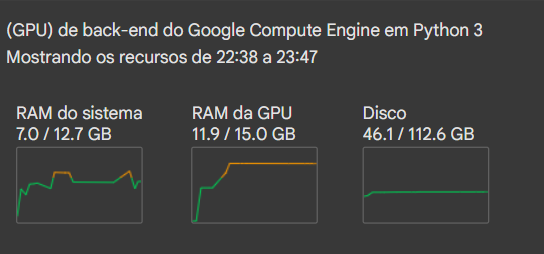